# 01 — Dataset Exploration

This notebook loads and explores the *scientific_papers/arxiv* dataset used for abstractive summarization.
We will:
1. Inspect dataset splits and fields.
2. Examine a few samples (article → abstract).
3. Analyze text length distributions.
4. Verify tokenization process for BART.

By the end, we’ll confirm that the dataset is correctly cached and ready for training.

In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, load_from_disk
from transformers import AutoTokenizer

# Local imports
from src.data_loader import load_or_build_tokenized
from src.seed_utils import set_seed

set_seed(42)

## Load the dataset

We'll load the *scientific_papers/arxiv* dataset through our data loader.
The first run downloads and tokenizes the full dataset; later runs reuse cached versions under `data/cache/`.

In [2]:
raw, tok = load_or_build_tokenized(
    dataset_name="scientific_papers",
    subset="arxiv",
    model_name="facebook/bart-base",
    max_input_len=1024,
    max_target_len=256
)

print(f"Splits: {list(raw.keys())}")
for split in raw:
    print(f"{split}: {len(raw[split])} samples")

/opt/anaconda3/lib/python3.12/site-packages/datasets/load.py:1486: FutureWarning: The repository for scientific_papers contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/scientific_papers
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Saving the dataset (0/15 shards):   0%|          | 0/203037 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6440 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Tokenizing scientific_papers/arxiv:   0%|          | 0/6440 [00:00<?, ? examples/s]

/opt/anaconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:3921: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Saving the dataset (0/17 shards):   0%|          | 0/203037 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6436 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/6440 [00:00<?, ? examples/s]

Splits: ['train', 'validation', 'test']
train: 203037 samples
validation: 6436 samples
test: 6440 samples


## Inspect dataset structure

Each entry contains:
- `article`: the full text (input)
- `abstract`: the target summary

Let's print one example to confirm.

In [3]:
sample = raw["train"][0]
print("=== ARTICLE EXCERPT ===")
print(sample["article"][:1000], "...")
print("\n=== ABSTRACT ===")
print(sample["abstract"])

=== ARTICLE EXCERPT ===
additive models @xcite provide an important family of models for semiparametric regression or classification . some reasons for the success of additive models are their increased flexibility when compared to linear or generalized linear models and their increased interpretability when compared to fully nonparametric models .
it is well - known that good estimators in additive models are in general less prone to the curse of high dimensionality than good estimators in fully nonparametric models .
many examples of such estimators belong to the large class of regularized kernel based methods over a reproducing kernel hilbert space @xmath0 , see e.g. @xcite . in the last years
many interesting results on learning rates of regularized kernel based models for additive models have been published when the focus is on sparsity and when the classical least squares loss function is used , see e.g. @xcite , @xcite , @xcite , @xcite , @xcite , @xcite and the references there

## Analyze article length distribution

Understanding input lengths helps decide on `max_input_len`.
We'll sample a few thousand entries to plot character and token distributions.

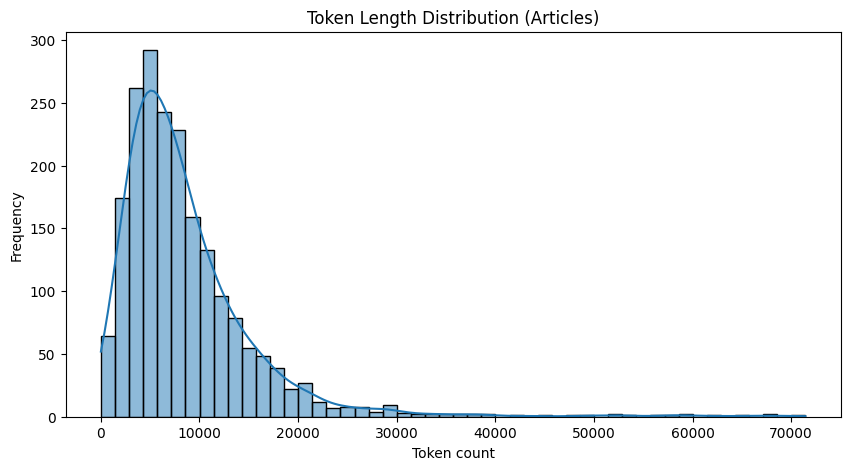

Average tokens: 8632.79
95th percentile: 20380


In [5]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base")

# Sample subset for faster stats
texts = [x["article"] for x in raw["train"].select(range(2000))]
lengths = [len(tokenizer.tokenize(t)) for t in texts]

plt.figure(figsize=(10,5))
sns.histplot(lengths, bins=50, kde=True)
plt.title("Token Length Distribution (Articles)")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

print(f"Average tokens: {np.mean(lengths):.2f}")
print(f"95th percentile: {np.percentile(lengths, 95):.0f}")

## Analyze abstract (summary) lengths

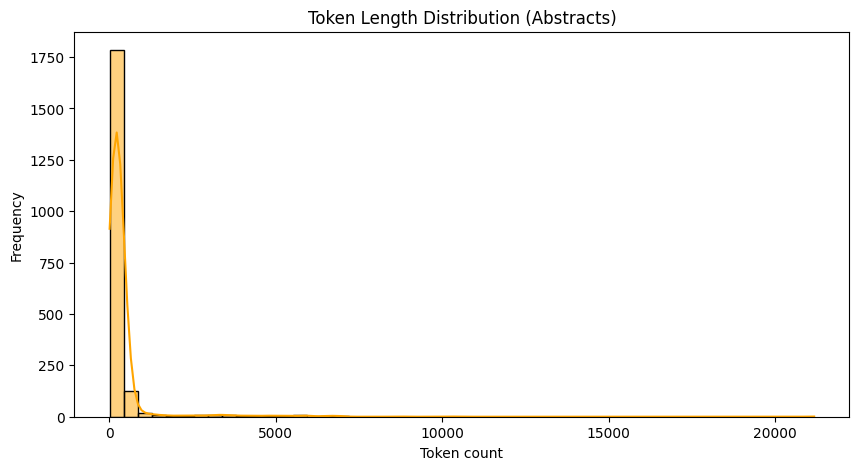

Average abstract tokens: 386.83
95th percentile: 699


In [6]:
summaries = [x["abstract"] for x in raw["train"].select(range(2000))]
sum_lens = [len(tokenizer.tokenize(t)) for t in summaries]

plt.figure(figsize=(10,5))
sns.histplot(sum_lens, bins=50, kde=True, color="orange")
plt.title("Token Length Distribution (Abstracts)")
plt.xlabel("Token count")
plt.ylabel("Frequency")
plt.show()

print(f"Average abstract tokens: {np.mean(sum_lens):.2f}")
print(f"95th percentile: {np.percentile(sum_lens, 95):.0f}")

## Verify tokenized dataset

Confirm that the tokenized cache matches expectations (input_ids, attention_mask, labels).

In [7]:
print(tok)
print(tok["train"].column_names)
print(tok["train"][0].keys())

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 203037
    })
    validation: Dataset({
        features: ['article', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 6436
    })
    test: Dataset({
        features: ['article', 'abstract', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 6440
    })
})
['article', 'abstract', 'input_ids', 'attention_mask', 'labels']
dict_keys(['article', 'abstract', 'input_ids', 'attention_mask', 'labels'])


## Stage 1 Notebook Summary

- Dataset successfully loaded and tokenized.
- Verified 3 splits (train/validation/test).
- Checked article and abstract length distributions.
- Confirmed cache integrity.

Next: move to **02_model_training.ipynb** for fine-tuning BART on this dataset.